In [12]:
import numpy as np, pandas as pd, time, warnings, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy.linalg import solve, norm
from scipy.optimize import minimize

warnings.filterwarnings("ignore", category=RuntimeWarning)   # silence exp overflow

# ---------- random feature expansion -------------------------------------------
def expand_features(X, k, seed=42, sparse=True):
    """30 features → 30·k via a random projection.  sparse keeps memory small."""
    if k == 1:
        return X
    rng  = np.random.default_rng(seed)
    n, d = X.shape
    D    = d * k
    if sparse:
        nnz = 3
        P   = np.zeros((d, D))
        for j in range(D):
            rows            = rng.choice(d, nnz, replace=False)
            P[rows,  j]     = rng.choice([-1, 1], nnz)
    else:                       # dense Gaussian
        P = rng.standard_normal((d, D))
    return X @ P                # (n, D)

def make_train_test(k=1):
    """return X_tr, X_te, y_tr, y_te    (bias column already added)."""
    df = pd.read_csv("wdbc.data", header=None)
    df = df.drop(columns=0)
    df[1] = df[1].map({'M':1, 'B':0})
    X    = df.drop(columns=1).values
    X    = expand_features(X, k)
    y    = df[1].values.reshape(-1,1)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=10
    )
    sc   = StandardScaler()
    X_tr = sc.fit_transform(X_tr); X_te = sc.transform(X_te)
    X_tr = np.c_[np.ones(X_tr.shape[0]), X_tr]
    X_te = np.c_[np.ones(X_te.shape[0]), X_te]
    return X_tr, X_te, y_tr, y_te

# ---------- logistic-loss pieces -----------------------------------------------
sigmoid = lambda z: 1/(1+np.exp(-z))
logloss = lambda p,y: -np.mean(y*np.log(p+1e-12)+(1-y)*np.log(1-p+1e-12))

def f(w,X,y):  return logloss(sigmoid(X@w), y)
def g(w,X,y):  return X.T @ (sigmoid(X@w)-y) / len(y)
def H(w,X):    p = sigmoid(X@w).ravel(); S = p*(1-p); return (X.T*S)@X / len(S)
def acc(w,X,y):return ((sigmoid(X@w)>=0.5).astype(int)==y).mean()

# ---------- Newton variants (small ridge for invertibility) ---------------------
def newton(w0,X,y,maxit=50,lam=1e-4,tol=1e-6):
    I, w, hist = np.eye(len(w0)), w0.copy(), []
    for _ in range(maxit):
        grad = g(w,X,y)
        if norm(grad)<tol: break
        w -= solve(H(w,X)+lam*I, grad)
        hist.append(f(w,X,y))
    return w, np.array(hist)

def lazy_newton(w0,X,y,k=5,maxit=50,lam=1e-4,tol=1e-6):
    I, w, hist = np.eye(len(w0)), w0.copy(), []
    Hk = H(w,X)+lam*I
    for it in range(maxit):
        grad=g(w,X,y)
        if norm(grad)<tol: break
        if it%k==0: Hk = H(w,X)+lam*I
        w -= solve(Hk,grad)
        hist.append(f(w,X,y))
    return w, np.array(hist)


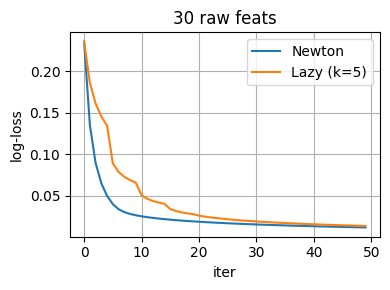

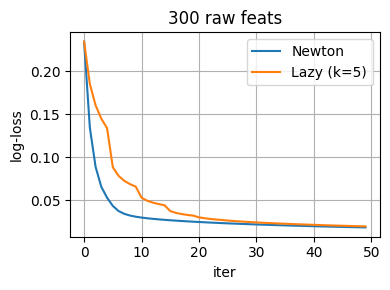

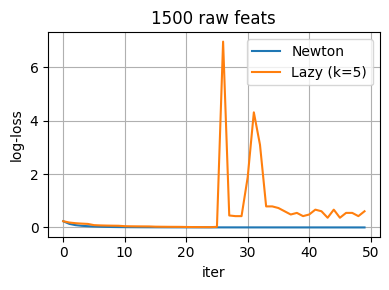

 raw d | method      | time(s) | iters | test acc
----------------------------------------------
    30 | Newton      |    0.01 |    50 |   0.939
    30 | Lazy-Newton |    0.00 |    50 |   0.930
    30 | BFGS        |    0.03 |     - |   0.947
    30 | L-BFGS      |    0.01 |     - |   0.947
   300 | Newton      |    0.08 |    50 |   0.947
   300 | Lazy-Newton |    0.05 |    50 |   0.947
   300 | BFGS        |    0.34 |     - |   0.947
   300 | L-BFGS      |    0.05 |     - |   0.947
  1500 | Newton      |    3.75 |    50 |   0.947
  1500 | Lazy-Newton |    2.85 |    50 |   0.965
  1500 | BFGS        |   11.88 |     - |   0.947
  1500 | L-BFGS      |    0.06 |     - |   0.956


In [13]:
factors = [1, 10, 50]          # 30→30, 30→300, 30→1500 raw feats
table   = []

for k in factors:
    X_tr,X_te,y_tr,y_te = make_train_test(k)
    d   = X_tr.shape[1]
    w0  = np.zeros((d,1))

    # -- Newton -----------------------------------------------------------------
    t0=time.perf_counter(); wN,lN = newton(w0,X_tr,y_tr);     tN=time.perf_counter()-t0

    # -- Lazy-Newton ------------------------------------------------------------
    t0=time.perf_counter(); wL,lL = lazy_newton(w0,X_tr,y_tr);tL=time.perf_counter()-t0

    # -- BFGS -------------------------------------------------------------------
    nll   = lambda v: f(v[:,None],X_tr,y_tr)
    gradl = lambda v: g(v[:,None],X_tr,y_tr).ravel()
    t0=time.perf_counter()
    wB   = minimize(nll,w0.ravel(),jac=gradl,method='BFGS',
                    options={'gtol':1e-6,'disp':False}).x[:,None]
    tB=time.perf_counter()-t0

    # -- L-BFGS (maxcor=10) -----------------------------------------------------
    t0=time.perf_counter()
    wLB  = minimize(nll,w0.ravel(),jac=gradl,method='L-BFGS-B',
                    options={'gtol':1e-6,'maxcor':10,'disp':False}).x[:,None]
    tLB=time.perf_counter()-t0

    # -- store results ----------------------------------------------------------
    table.append([d-1,                           # raw features
                  ("Newton",     tN,  len(lN),  acc(wN,X_te,y_te)),
                  ("Lazy-Newton",tL,  len(lL),  acc(wL,X_te,y_te)),
                  ("BFGS",       tB,           None, acc(wB,X_te,y_te)),
                  ("L-BFGS",     tLB,          None, acc(wLB,X_te,y_te))])

    # loss-curve plot (Newton variants only)
    plt.figure(figsize=(4,3))
    plt.plot(lN,label="Newton"); plt.plot(lL,label="Lazy (k=5)")
    plt.title(f"{d-1} raw feats"); plt.xlabel("iter"); plt.ylabel("log-loss")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ---------- print summary table -------------------------------------------------
print(f"{'raw d':>6} | {'method':<11} | {'time(s)':>7} | {'iters':>5} | {'test acc':>7}")
print('-'*46)
for row in table:
    d = row[0]
    for name,t,it,acc_val in row[1:]:
        print(f"{d:6} | {name:<11} | {t:7.2f} | "
              f"{'-' if it is None else it:>5} | {acc_val:7.3f}")

